<a href="https://colab.research.google.com/github/royzah/SkripsiNisa/blob/main/Skripsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

In [ ]:
torch.__version__

'1.13.1+cu116'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from torchvision import transforms
import numpy as np
from PIL import Image, ImageDraw
#import mmcv
from IPython import display

import sys
sys.path.append("/content/drive/MyDrive/NISAUSYSYAKIROH")
from model import create_model
import utils

%load_ext autoreload
%autoreload 2


In [ ]:
def plot(img, pred, threshold=0.5):
    plt.figure(figsize=(20,20));
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(pred.cpu().numpy()[0]>threshold)
    plt.title('Segmentation Output')
    plt.axis('off')

def show_images(images, cols=1, prefix='Image ', titles=None):
    # https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = [f'{prefix} ({i})' for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

def pred(image, model):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
        return output

In [ ]:
model_path = '/content/drive/MyDrive/NISAUSYSYAKIROH/model.pth'
#video_path = '/content/drive/MyDrive/NISAUSYSYAKIROH/main/video.mp4'
threshold = 0.1

model = create_model()
checkpoint = torch.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

if torch.cuda.is_available():
    model.to('cuda')
    print('Cuda is On')

else:
    print('CPU only')

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Cuda is On


In [ ]:
# image = Image.open(f'/content/drive/MyDrive/NISAUSYSYAKIROH/Dataset/AOLP/Image/29.jpg').convert('RGB')
# image = Image.open(f'/content/drive/MyDrive/NISAUSYSYAKIROH/Dataset/AOLP/Image/51.jpg').convert('RGB')
# image = Image.open(f'/content/drive/MyDrive/NISAUSYSYAKIROH/Dataset/AOLP/Image/78.jpg').convert('RGB')
# image = Image.open(f'/content/drive/MyDrive/NISAUSYSYAKIROH/Dataset/AOLP/Image/80.jpg').convert('RGB')
# image = Image.open(f'/content/drive/MyDrive/NISAUSYSYAKIROH/Dataset/AOLP/Image/100.jpg').convert('RGB')
# image = Image.open(f'/content/drive/MyDrive/NISAUSYSYAKIROH/Dataset/AOLP/Image/353.jpg').convert('RGB')
# image = Image.open(f'/content/drive/MyDrive/NISAUSYSYAKIROH/Dataset/AOLP/Image/355.jpg').convert('RGB')
# image = Image.open(f'/content/drive/MyDrive/NISAUSYSYAKIROH/Dataset/AOLP/Image/356.jpg').convert('RGB')
# image = Image.open(f'/content/drive/MyDrive/NISAUSYSYAKIROH/Dataset/AOLP/Image/362.jpg').convert('RGB')
image = Image.open(f'/content/drive/MyDrive/NISAUSYSYAKIROH/Dataset/AOLP/Image/368.jpg').convert('RGB')
outputs = pred(image=image, model=model)

mask = outputs.cpu().numpy()[0]>0.1
mask = mask.astype(np.uint8)

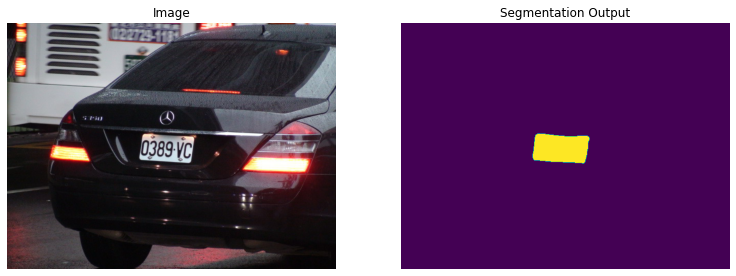

In [ ]:
plot(image, outputs, threshold=0.1)

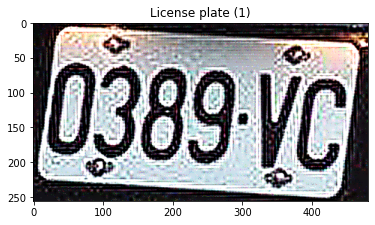

In [ ]:
license_plates = utils.extract_segmentation_results(image, mask, sharpen_amount=50)
show_images(license_plates, prefix='License plate')

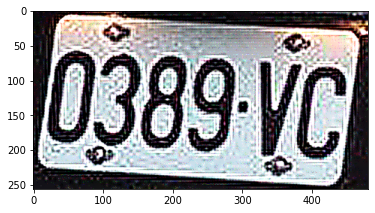

In [ ]:
plt.imshow(license_plates[0])

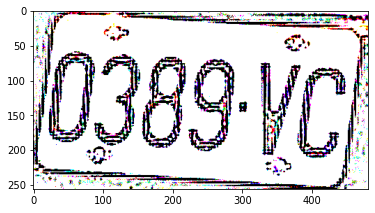

In [ ]:
plate_image = cv2.convertScaleAbs(license_plates[0], alpha=(255.0))
plt.imshow(plate_image)

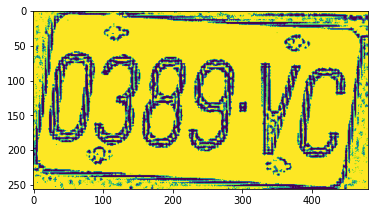

In [ ]:
gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

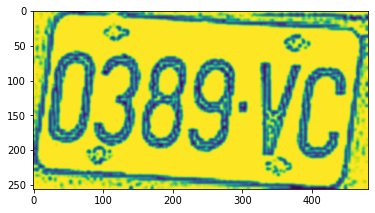

In [ ]:
blur = cv2.GaussianBlur(gray,(7,7),0)
plt.imshow(blur)

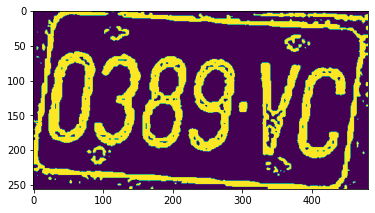

In [ ]:
binary = cv2.threshold(blur, 180, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
plt.imshow(binary)

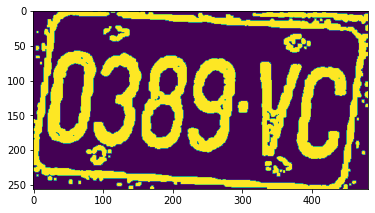

In [ ]:
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
plt.imshow(thre_mor)

In [ ]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))
    return cnts

In [ ]:
cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)
            
print("Detect {} letters...".format(len(crop_characters)))     

Detect 6 letters...


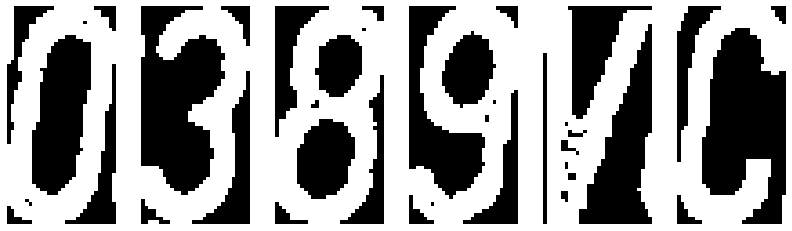

In [ ]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14,4))
grid = GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")